# Introduction

This notebook is created to summarize a conversation had between Ben Prytherch and Preston Dunton on March 1, 2022 about correlated errors.

The purpose of the project is to help show the differences between what the drummer plays and what they're supposed to play.  This can be though of as the difference between two vectors (lists) of timestamps.  These timestamps can be in units of seconds, milliseconds, or even beats at a given tempo.  The unit doesn't really matter, as there are unit conversions between all of them.  Feel free to think about whichever makes the most sense to you.

$$\overrightarrow{m}=\begin{bmatrix}0 \\ 1 \\ 2 \\ 3 \\ 4 \\ 5 \\ . \\ . \\ .\end{bmatrix}\;\;\;\;\overrightarrow{t}=\begin{bmatrix}0.1 \\ 1.15 \\ 2.07 \\ 2.96 \\ 3.92 \\ 4.87 \\ . \\ . \\ .\end{bmatrix}$$


Let $\overrightarrow{m}$ be the "MIDI Vector," containing the timestamps calculated from the MIDI.  This represents the times that a player's stick would hit the drum if they were playing *perfectly* in time, and is the "correct" data.

The other vector, $\overrightarrow{t}$ is the "Transient Vector," and contains the timestamps computed from the audio of the drummer actually playing.  It's called the transient vector because it is made by identifying transients in the audio file recorded by the drummer.  If the drummer is any good, these timestamps should be an approximation of the MIDI vector $\overrightarrow{m}$.

The differences in these two vectors represents how early or late the drummer was to each note.  The two vectors can be subtracted to create an "error vector":

$$\overrightarrow{e}=\overrightarrow{t}-\overrightarrow{m}=\begin{bmatrix}0.1 \\ 1.15 \\ 2.07 \\ 2.96 \\ 3.92 \\ 4.87 \\ . \\ . \\ .\end{bmatrix}-\begin{bmatrix}0 \\ 1 \\ 2 \\ 3 \\ 4 \\ 5 \\ . \\ . \\ .\end{bmatrix}=\begin{bmatrix}0.1 \\ 0.15 \\ 0.07 \\ -0.04 \\ -0.08 \\ -0.13 \\ . \\ . \\ .\end{bmatrix}$$

Just like the MIDI vector and the transient vector, there is one entry per note.  If the entry is positive, that means the drummer's transient was later than the time that it was supposed to be, and the drummer was behind.  If the entry is negative, that means the drummer's transient was earlier than the time it was supposed to be, and the drummer is ahead.

$$\begin{bmatrix}0.1 \\ 0.15 \\ 0.07 \\ -0.04 \\ -0.08 \\ -0.13 \\ . \\ . \\ .\end{bmatrix}\longrightarrow\begin{bmatrix}\text{Late} \\ \text{Late} \\ \text{Late} \\ \text{Early} \\ \text{Early} \\ \text{Early} \\ . \\ . \\ .\end{bmatrix}$$

In statistical modeling, there is a general assumption that errors are uncorrelated.  In other words, we assume that the error in one observation or prediction has nothing to do with any other observation or prediction.  In this time-series data, this is clearly not the case.  If a drummer is late to a note, they are almost certainly going to be late to the notes immediately following.  A similar argument can be made for being early to notes as well.  Knowing one error provides some information about the errors following it, which means that the errors *are* correlated!  Because this assumption is clearly violated, we must be careful about how report these errors, as usual statistical methods might misrepresent the drummers ability.  

This notebook explores the implications of correlated errors and discusses how they might be reported to the user.

# Toy Data

To show different cases that might commonly occur, let's picture some toy data.  Let's say our drummer is asked to play two measures of eight notes and a release.  This would look like 
<center>
<img src="./images/expected_excerpt.PNG" alt="Two Measures of Eight Notes" width="500"/>
</center>

Now suppose that the drummer only makes mistakes by a sixteenth-note at a time.  This doesn't really make sense, but it allows us to write down the drummer's mistakes in music notation.  Let's consider four types of errors that players might typically make in their extreme cases. 

**Late with no recovery**

<center>
<img src="./images/late_no_recovery.PNG" alt="Two Measures of Eight Notes" width="500"/>
</center>


**Late with recovery**

<center>
<img src="./images/late_with_recovery.PNG" alt="Two Measures of Eight Notes" width="500"/>
</center>

**Double late**

<center>
<img src="./images/double_late.PNG" alt="Two Measures of Eight Notes" width="500"/>
</center>

**Late to first note**

<center>
<img src="./images/late_to_first_note.PNG" alt="Two Measures of Eight Notes" width="500"/>
</center>

Below are some examples of those vectors $\overrightarrow{t}$ and $\overrightarrow{m}$ for these different examples.  We'll use these to plot our errors over time.

In [1]:
import numpy as np

m = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

in_time_t = m
late_no_recovery_t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17])
late_with_recovery_t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 12, 13, 14, 15, 16])
double_late_t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18])
late_first_note_t = np.array([1, 2, 3, 4, 5,  6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])


# Visualizing Errors 

It might be useful to visualize the errors over time in a graph.  This way, we can identify mistakes a drummer might make and how they may or may not correct their mistake.  We can also view smaller errors that the player is likely to make on each note, as it is very unlikely that they will hit any note at its exact timestamp.

The code below creates some plots to visualize the four cases introduced above.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import collections as matcoll

def plot_error(t,m, title='', noise=0.05, absolute_errors=False, relative_errors=False):
    with plt.xkcd():
        error = (t - m).astype('float64')
        
        y_min, y_max = -1.5 * abs(max(error, key=abs)), 1.5 * abs(max(error, key=abs))
        if y_min == y_max:
            if y_min == 0:
                y_min, y_max = -1, 1

        x_min, x_max = -1, 1.2 * max(m)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.axhline(0)

        plt.ylabel('Error (e vector)', fontsize=16)
        plt.xlabel('Time (m vector)', fontsize=16)
        plt.xticks([])
        plt.yticks([0], fontsize=14)

        error += np.random.normal(0,noise, len(error))
        if absolute_errors:
            markerline, stemlines, baseline = plt.stem(m, error, markerfmt='o')
            plt.setp(stemlines, 'color', 'black')
            plt.setp(markerline, 'color', 'black')
            plt.setp(baseline, 'color', 'black')
        else:
            plt.plot(m, error, 'o', color='black')

        if relative_errors:
            lines = []
            for i in range(1,len(error)):
                pair = [(m[i], error[i-1]), (m[i], error[i])]
                lines.append(pair)
            linecoll = matcoll.LineCollection(lines, colors='k')
            plt.gca().add_collection(linecoll)
            
        plt.title(title, fontsize=20)

        plt.axvspan(-1, 1.5 * max(m), 0.5, 1, alpha=0.3, color='#1F98D0') #blue
        plt.axvspan(-1, 1.5 * max(m), 0, 0.5, alpha=0.3, color='#F9D307') #yellow
        plt.annotate('Behind', (0.1 * x_max, 0.3 * y_max), fontsize=60, alpha=0.05)
        plt.annotate('Ahead', (0.125 * x_max, 0.7 * y_min ), fontsize=60, alpha=0.05)

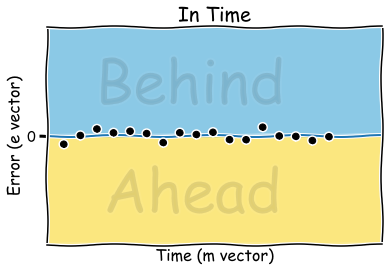

In [3]:
plot_error(in_time_t, m, 'In Time')

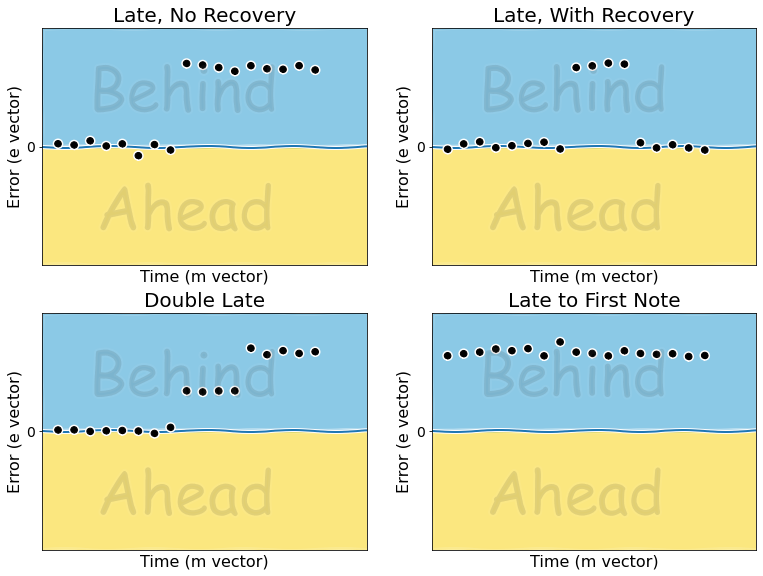

In [4]:
plt.figure(figsize=(12.8,9.6))

plt.subplot(2,2,1)
plot_error(late_no_recovery_t, m, 'Late, No Recovery')

plt.subplot(2,2,2)
plot_error(late_with_recovery_t, m, 'Late, With Recovery')

plt.subplot(2,2,3)
plot_error(double_late_t, m, 'Double Late')

plt.subplot(2,2,4)
plot_error(late_first_note_t, m, 'Late to First Note')

# Reporting Errors

The trick with reporting these correlated errors is that we don't want to penalize the player multiple times for mistakes that occured earlier.  For example, take the **Late, no recovery** example.  The player only really made one mistake, but half of the notes lie away from the $\text{Error}=0$ line. Asumming uncorrelated errors, usual statistics methods report aggregations of these errors, represented by the vertical lines below.  Call these errors **Absolute Errors**:

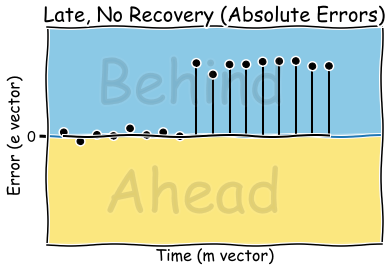

In [5]:
plot_error(late_no_recovery_t, m, 'Late, No Recovery (Absolute Errors)', absolute_errors=True)

In this example, there is only one mistake, really.  One way we could reflect this statistically is to only report errors of each note relative to the error of the previous note.  Call these errors **Relative Errors**.  In the plot below, we only draw lines from each point to the error level of the previous point.  Notice how the lines after the mistake are much smaller in the plot below than in the plot above.

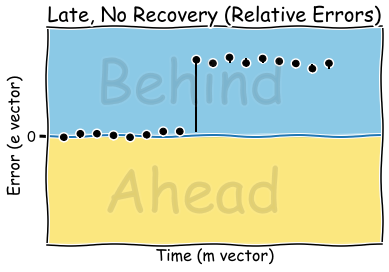

In [6]:
plot_error(late_no_recovery_t, m, 'Late, No Recovery (Relative Errors)', relative_errors=True)

There are advantages and disadvantages to reporting errors both ways.  

For example, absolute errors can be excessively harsh for players playing without a metronome.  If they make a mistake and don't realize it, it's very difficult to recover, and they shouldn't be penalized for good playing after their mistake.  Relative errors are good for this case because they still capture mistakes while accommodating for mistakes made eariler in time.

On the contrary, if the player does have a metronome and they fail to recover from their mistake, it is fair to penalize them for that.  They are receiving auditory information that should allow them to recover, and by not recovering, they are committing more errors.  Absolute errors are good for when a player is expected to recover.

The two methods of reporting errors can also be used for players of different levels of experience.  More experienced players can be evaluated more harshly with absolute errors, while relative errors might be better for younger players.  Information from absolute errors might also be more overwhelming than information from relative errors.  Relative errors has an advantage of showing where the largest mistakes lie, where absolute errors just show every deviation from what is "perfectly in time."

Here's the absolute and relative errors for the **Double late** example:

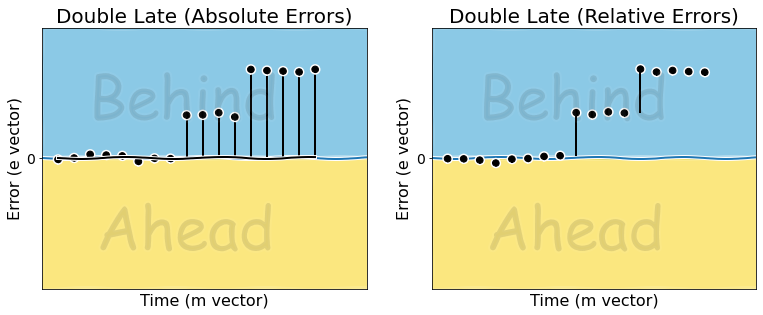

In [7]:
plt.figure(figsize=(12.8,4.8))

plt.subplot(1,2,1)
plot_error(double_late_t, m, 'Double Late (Absolute Errors)', absolute_errors=True)

plt.subplot(1,2,2)
plot_error(double_late_t, m, 'Double Late (Relative Errors)', relative_errors=True)

Now consider the **Late with recovery** example:

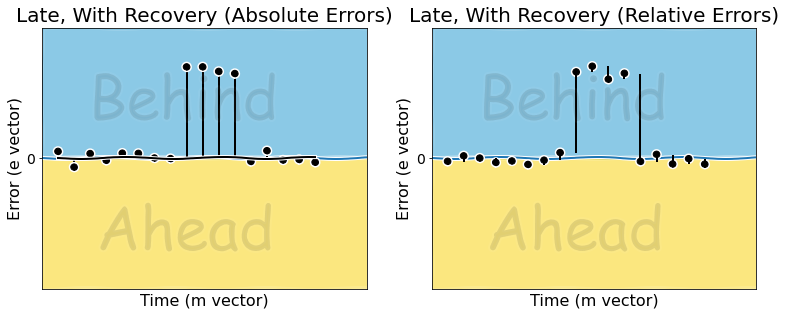

In [8]:
plt.figure(figsize=(12.8,4.8))

plt.subplot(1,2,1)
plot_error(late_with_recovery_t, m, 'Late, With Recovery (Absolute Errors)', absolute_errors=True)

plt.subplot(1,2,2)
plot_error(late_with_recovery_t, m, 'Late, With Recovery (Relative Errors)', relative_errors=True)

This example becomes more tricky to think about because using absolute errors, the first note after the recovery has very little error (a small line), wheras with relative errors, the first note after the recovery has a huge error (a large line).  

With absolute errors, we don't have to worry about which changes in timing are mistakes and which are recoveries because they already take into account errors that occured earlier in time (they are correlated). Relative errors, however, will penalize for both because they don't consider errors that occured earlier (they are not correlated).  

Finally, consider the last case, **Late to first note**:

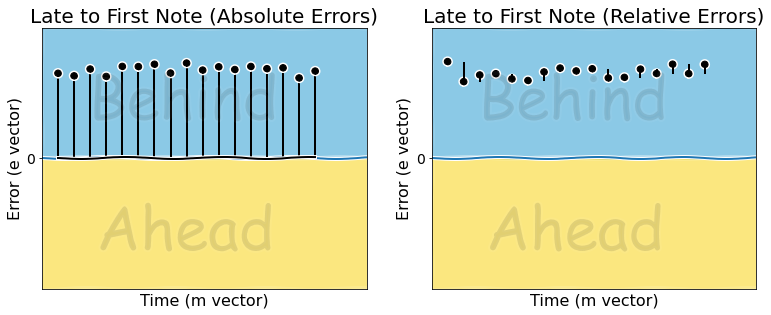

In [9]:
plt.figure(figsize=(12.8,4.8))

plt.subplot(1,2,1)
plot_error(late_first_note_t, m, 'Late to First Note (Absolute Errors)', absolute_errors=True)

plt.subplot(1,2,2)
plot_error(late_first_note_t, m, 'Late to First Note (Relative Errors)', relative_errors=True)

In this case, notice that absolute errors are very large for every single note, while relative errors are very small for every note.  For players playing with a metronome, they'd have to be extremely bad to be late on the first note and not recover the whole time.  In this case, absolute errors make sense to report.  However, if there isn't a metronome for the player to listen to, then the relative errors show that the person is playing each note nearly perfectly in time.

This example gets at the quetsion "How do we know if the first note is in time?"  This question will be addressed later in the project.

# Speeding Up and Slowing Down

Speeding up and slowing down are common mistakes that drummers make.  Here's what they would look like in these plots:

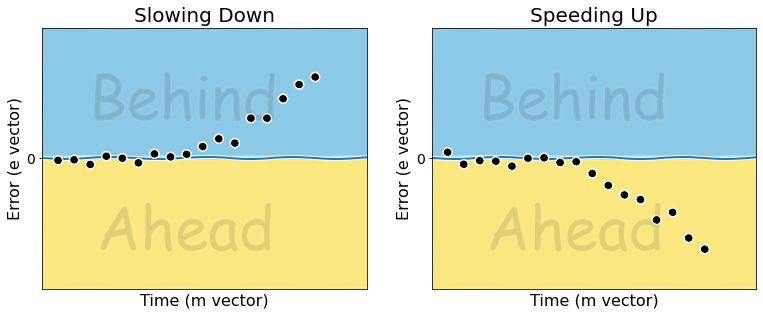

In [10]:
plt.figure(figsize=(12.8,4.8))
plt.subplot(1,2,1)
t = np.array([0,1,2,3,4,5,6,7,8.5,10,11.5,13,15,17,19.5,22,24.5])
plot_error(t,m, 'Slowing Down', noise=0.4)

plt.subplot(1,2,2)
t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 7.5, 8, 8.25, 8.5, 8.6, 8.7, 8.75, 8.8, 8.825])
plot_error(t,m, 'Speeding Up', noise=0.4)

Not only do the errors drift away from the zero line, but they are doing so at a faster and faster rate.  This will also be dealt with later in the project.